# INFO-F-422 -  Statistical Foundations of Machine Learning 

### De Vos Sebastien - __[Sebastien.De.Vos@ulb.be](mailto:sebastien.de.vos@ulb.be) - Student ID 459907__
### Kalai Tarik - __[Tarik.Kalai@ulb.be](mailto:Tarik.Kalai@ulb.be) - Student ID 459631__
### Rubas Diego - __[Diego.Rubas@ulb.be](mailto:diego.rubas@ulb.be) - Student ID 459733__

### Video presentation: www.youtube.com/abcd1234

## Flu Shot Learning: Predict H1N1 and Seasonal Flu Vaccines


# Table of Contents

* [Introduction](#Introduction)
* [Exploratory Data Analysis](#Exploratory_Data_Analysis)
    * [Data Loading](#Data_Loading)
    * [Data Dimension](#Data_Dimension)
    * [Data Preview](#Data_Preview)
* [Data Preprocessing](#Data_Preprocessing)
    * [Missing Value Imputation](#Missing_Value_Imputation)
    * [Feature Engineering](#Feature_Engineering)
    * [Feature Selection](#Feature_Selection)
* [Model Selection](#Model_Selection)
    * [Model 1: Linear Model](#Model_1_Linear_Model)
    * [Model 2: Decision Tree](#Model_2_Decision_Tree)
        [Model 2.1: Bossted Decision Tree](#Model_2_1_Boosted_Decision_Tree)
    * [Model 3: Random Forest](#Model_3_Random_Forest)

# Introduction <a class="anchor" id="Introduction"></a>

4 different models will be used to predic if either a person received the h1n1 vaccine or/and the seasonnal flu vaccine.
The four different models are: 

  * Linear Regression Model. 
  * Decision Tree Model.
    * Boosted version.
  * Random Forest.
  * Neural Network.


### Seed for the project

In [2]:
set.seed(12345)

# Exploratory Data Anaylsis <a class="anchor" id="Exploratory_Data_Analysis"></a>

In this section we will be viewing and understanding the data. 

## Data loading <a class="anchor" id="Data_Loading"></a>

In [3]:
training_set_features <- read.csv("sample_data/training_set_features.csv", stringsAsFactors  = T)
training_set_labels <- read.csv("sample_data/training_set_labels.csv", stringsAsFactors  = T)
test_set_features <- read.csv("sample_data/test_set_features.csv", stringsAsFactors  = T)
submission_format <- read.csv("sample_data/submission_format.csv", stringsAsFactors  = T)


## Dimensions of the data samples. <a class="anchor" id="Data_Dimension"></a>

We realised that the *training_set_labels* is the known prediction that will be used to train our models with the *training_set_features*.
What will have to be uploaded on the DrivenData website is the prediction of the *test_set_features* which has to correspond to the format of *submission_format*. 

In [4]:
cat("dimension of training_set_features : ", dim(training_set_features), "\n")
cat("dimension of training_set_labels: ", dim(training_set_labels), "\n")
cat("dimension of test_set_features: ",  dim(test_set_features), "\n")
cat("dimension of submission_format : ", dim(submission_format), "\n")

dimension of training_set_features :  26707 36 
dimension of training_set_labels:  26707 3 
dimension of test_set_features:  26708 36 
dimension of submission_format :  26708 3 


## Data Preview <a class="anchor" id="Data_Preview"></a>

In [5]:
head(training_set_features)
head(training_set_labels)

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,⋯,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<fct>
1,0,1,0,0,0,0,0,0,1,1,⋯,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0,0,,
2,1,3,2,0,1,0,1,0,1,1,⋯,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0,0,pxcmvdjn,xgwztkwe
3,2,1,1,0,1,0,0,0,0,0,⋯,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2,0,rucpziij,xtkaffoo
4,3,1,1,0,1,0,1,1,0,0,⋯,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0,0,,
5,4,2,1,0,1,0,1,1,0,1,⋯,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1,0,wxleyezf,emcorrxb
6,5,3,1,0,1,0,1,0,0,1,⋯,"<= $75,000, Above Poverty",Married,Own,Employed,atmpeygn,"MSA, Principle City",2,3,saaquncn,vlluhbov


,respondent_id,h1n1_vaccine,seasonal_vaccine
,<int>,<int>,<int>
1,0,0,0
2,1,0,1
3,2,0,0
4,3,0,1
5,4,0,0
6,5,0,0


# Data preprocessing <a class="anchor" id="Data_Preprocessing"></a>

In this part, all the different methods to pre-process the data are listed : 

* cleanData: clean the first 22 binary features, as they are integers if there are missing datas ("NA") then they will be replaced by the mean value while considering the standard deviation.  
* transform_na: compute the mean and standard deviation and replace the "NA" by 
\begin{equation*}
x(NA) = \bar{x} + \sigma(x)/2
\end{equation*}

* norm: Compute the norm for a given feature to normalize its values. 
* one_hot_encoding: Way to deal with the categorical features in order to make them usable for some models (Linear Regression modeling for example.)
* cast_into_double: cast a given feature into double in order to respect the format of the submission format. 

In [6]:
cleanData <- function(x) {
    for (i in 2:22) {
        x <- transform_na(x, i)
    }
    return(x)
}

transform_na <- function(x, index){
    if (length(which(is.na(x[,index]))) > 0){ #Check if there is any NA in the column
            mean_ts <- mean(x[,index], na.rm = T) #compute old_mean
            sd_ts <- sqrt(var(x[,index], na.rm = T)) #compute old_sd
            x[is.na(x[,index]), index] <- round(mean_ts + sd_ts/2) #modify the data
        }
    return(x)
}

norm<-function(x){
    return( (x-min(x)) / (max(x)-min(x)) )
}

one_hot_encoding <- function(x, index) {
    names <- levels(x[,index]) # get the names of all the possible different values
    new_col <- model.matrix(~0+x[,index]) # transforms the column in a matrix with a '1' in the correct column and '0' otherwise
    attr(new_col, "dimnames")[[2]] <- names
    new_col <- as.data.frame(new_col)
    x <- data.frame(x[1:index-1],new_col,x[(index+1):ncol(x)])
    return(x)
}

cast_into_double <- function(x){
    for (i in 2:length(x)){
        x[,i] <- as.numeric(x[,i])
    }
    return(x)
}


## Data Processing for each feature<a class="anchor" id="Data_Processing_For_Each_Feature"></a>

The data was handled as follows: 

* feature 1: This feature is used as id and does not need any cleaning. 
* feature 2 -> 22, 33, 34: These features are integers,the only subtlety was that "NA" values needed to be replaced. 
* features 23, 24, 27 : As there was ordering in this data, integer encoding was applied to it.
* features 25, 26, 28, 29, 30, 32 : For these categorical features, one hot encoding was applied.
* features 31, 35, 36: These features were considered useless (too many missing values). 

The data sorting function is general so it can be applied to the *test_set_features*. 

In [7]:

data_sorting <- function(x){

    # for feature 2 -> 22
    x <- cleanData(x)

    # for feature 23
    levels(x[,23]) <- c(1, 2, 3, 4, 5)

    # for feature 24
    levels(x[,24]) <- c(0, 1, 2, 4, 3)

    # for feature 25
    x <- one_hot_encoding(x, 25)

    # for feature 26 -> number 29
    x <- one_hot_encoding(x, 29)

    # for feature 27 -> number 31 !!! it need to be changed, it is not a good way to sort this data.
    levels(x[,31]) <- c(0, 2, 1, 3) 

    # for feature 28 -> number 32
    levels(x[,32])[1] <- 'marital_status_not_specified'
    x <- one_hot_encoding(x, 32)

    # for feature 29 -> number 35
    levels(x[,35])[1] <- 'rental_not_specified'
    x <- one_hot_encoding(x, 35)

    #for features 30 -> number 38
    levels(x[,38])[1] <- 'employment_not_specified'
    x <- one_hot_encoding(x, 38)
    
    # for feature 31 -> 42, we judged its contribution was negligeable against its cost of implementation
    x <- subset(x, select = -42)

    # for feature 32 -> 42 (since we dropped last column
    x <- one_hot_encoding(x, 42)

    # for feature 33 -> 45
    x <- transform_na(x, 45)

    # for feature 34 -> 46
    x <- transform_na(x, 46)

    # for feature 35 -> 47, we judged its contribution was negligeable against its cost of implementation
    x <- subset(x, select = -47)

    # for feature 36 -> 47, we judged its contribution was negligeable against its cost of implementation
    x <- subset(x, select = -47)

    x <- cast_into_double(x)
    name <- names(x)[-1]
    temp <- apply(x[2:length(x)], 2 , norm)
    attr(temp, "dimnames")[[2]] <- name
    x <- data.frame(x[1],as.data.frame(temp))
    return (x)
}

training_sf <- data_sorting(training_set_features)
test_sf <- data_sorting(test_set_features)

cat("Preview of the training_set_feature: \n")
head(training_sf[41:46])
cat("Dimension of training_set_feature: \n")
dim(training_sf)

Preview of the training_set_feature: 


,Unemployed,MSA..Not.Principle..City,MSA..Principle.City,Non.MSA,household_adults,household_children
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,1,0.0000000,0
2,0,1,0,0,0.0000000,0
3,0,1,0,0,0.6666667,0
4,0,0,1,0,0.0000000,0
5,0,1,0,0,0.3333333,0
6,0,0,1,0,0.6666667,1


Dimension of training_set_feature: 


[1] 26707    46


## Feature Engineering<a class="anchor" id="Feature_Engineering"></a>

TODO



## Feature Selection<a class="anchor" id="Feature_Selection"></a>

TODO

# Model selection <a class="anchor" id="Model_Selection"></a>



## Model 1 : Linear Regression <a class="anchor" id="Model_1_Linear_Model"></a>

For the first model we decided to go with a linear regreassion. 
Thus there has been a selection on the features, some feature where to correlated (notably, all the one which were "one hot encoded"), and thus have been removed. This corresponds to the features : 

* 27 -> race = Other.or.Multiple 
* 30 -> sexe = male
* 33 -> marital status = not specified
* 35 -> rent or own = rental_not_specified
* 38 -> employement  = employment_not_specified
* 44 -> census_msa = Non.MSA

The training_set_features cleaned has been put into a matrix appended with a first column of only ones. This colmumns will corresponds to the beta_0 coefficient.
We have then computed the beta_hat, so the estimation of the the coefficient for each feature. The prediction could then be made and a confusion matrix has been build.
With the same bata_hat, prediction for the test_set_features has been made and uploaded on the drivenData web site the values for the 

In [8]:
temp <- training_sf[-c(27, 30, 32, 35, 38, 44)] # i just looked at which one made the computation impossible in a greedy manner.

n <- length(temp)-1 # number of features
p <- n+1
N <- length(temp[,1]) # number of samples
N2 <- length(test_sf[,1])
Y <- as.matrix(training_set_labels[2:3])
Y_bar <- apply(Y, 2, mean)
X <- as.matrix(cbind(array(1,c(N,1)),temp[2:p]))

beta_hat <- array(0, c(p,2))
sigma_hat_w <- numeric(2)
Y_hat <- array(0, c(N,2))


temp_2  <- test_sf[-c(27, 30, 32, 35, 38, 44)]
p <- length(temp_2)
X_final <-  as.matrix(cbind(array(1,c(N2,1)),temp_2[2:p]))
Y_final <- array(0, c(N2,2))

my_tables <- list(table(Y_hat[,1], Y[,1]), table(Y_hat[,2], Y[,2]))
threshold <- 0.5

for (i in 1:2){
    beta_hat[,i] <- solve((t(X)%*%X))%*%t(X)%*%Y[,i] #doesn't work, we need to identify the features that are highly correlated and keep only one. 
    Y_hat[,i] <- X %*% beta_hat[,i]
    Y_final[,i] <- X_final %*% beta_hat[,i]
    e <- Y[,i] - Y_hat[,i]
    sigma_hat_w[i] <- sqrt((t(e)%*%e)/(N-p))
    Y_hat[,i] <- ifelse(Y_hat[,i] > threshold,1,0) 
    my_tables[[i]] <- table(Y_hat[,i], Y[,i])
}

In [9]:
print(paste("confusion matrix for h1n1_vaccine : "))
my_tables[[1]]
#sigma_hat_w[1]
confusion_matrix <- my_tables[[1]]
accuracy = (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)
misclassification_rate = 1 - accuracy
print(paste("misclassification rate for the h1n1_vaccine : ", misclassification_rate))
cat("\n")

print(paste("confusion matrix for seasonal_vaccine : "))
my_tables[[2]]
#sigma_hat_w[2]
confusion_matrix <- my_tables[[2]]
accuracy = (confusion_matrix[1,1]+confusion_matrix[2,2])/sum(confusion_matrix)
misclassification_rate = 1 - accuracy
print(paste("misclassification rate for the seasona_vaccine : ", misclassification_rate))

[1] "confusion matrix for h1n1_vaccine : "


   
        0     1
  0 19951  3412
  1  1082  2262

[1] "misclassification rate for the h1n1_vaccine :  0.16827049088254"

[1] "confusion matrix for seasonal_vaccine : "


   
        0     1
  0 11355  3342
  1  2917  9093

[1] "misclassification rate for the seasona_vaccine :  0.23435803347437"


In [10]:

Y_final<-ifelse(Y_final<=0,0.01,Y_final)
Y_final<-ifelse(Y_final>=1,0.99,Y_final)

submission <- data.frame(submission_format[1],Y_final)
colnames(submission)[2:3] <- c(names(submission_format[2:3]))
cat("\n")
print(paste("prediction for the test_set_features :"))
head(submission)
write.csv(submission, "sample_data/linear_answers.csv", row.names = FALSE, quote=FALSE)



[1] "prediction for the test_set_features :"


,respondent_id,h1n1_vaccine,seasonal_vaccine
,<int>,<dbl>,<dbl>
1,26707,0.06282598,0.2397931
2,26708,0.01169483,0.0100000
3,26709,0.38061953,0.6088012
4,26710,0.50194488,0.8584078
5,26711,0.25134780,0.4908154
6,26712,0.42346578,0.9004768


### F - test

- **Hypothesis**: $\beta_i=0$ for i > 1
- **Test statistic**: $\frac{SS_{mod}}{SS_{res}/(N-2)} \sim F_{1,N-2} $

In [1]:
SS_mod <- sum((Y_hat[,1]-Y_bar[1])^2)
SS_res <- sum((Y[,1]-Y_hat[,1])^2)
F_stat <- SS_mod / (SS_res/(N-2))
F_prob <- (1-pf(F_stat,df1=1,df2=N-2))
I <- seq(0,5,0.05)
plot(I,df(I,df1=1,df2=N-2),xlab="Statistic value",ylab="Probability",main="Probability distribution of the F-test statistic")
abline(v=F_stat,col="red")
print(paste("F-test result: F.value= ",F_stat))
print(paste("Pr[F >= F.value]= ", F_prob))

ERROR: Error in eval(expr, envir, enclos): object 'Y_hat' not found


In [327]:
print(paste("F-test result: F.value= ",F_stat))
print(paste("Pr[F >= F.value]= ", F_prob))

[1] "F-test result: F.value=  18591.1248010748"
[1] "Pr[F >= F.value]=  0"


## Model 2 <a class="anchor" id="Model_2_Decision_Tree"></a>

In [38]:
spam <- data.frame(training_set_features[2:length(training_set_features)], training_set_labels[2]) 
head(spam)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,⋯,employment_not_specified,Employed,Not.in.Labor.Force,Unemployed,MSA..Not.Principle..City,MSA..Principle.City,Non.MSA,household_adults,household_children,h1n1_vaccine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.3333333,0.0,0,0,0,0,0,1,1,0,⋯,0,0,1,0,0,0,1,0.0000000,0,0
2,1.0000000,1.0,0,1,0,1,0,1,1,0,⋯,0,1,0,0,1,0,0,0.0000000,0,0
3,0.3333333,0.5,0,1,0,0,0,0,0,0,⋯,0,1,0,0,1,0,0,0.6666667,0,0
4,0.3333333,0.5,0,1,0,1,1,0,0,0,⋯,0,0,1,0,0,1,0,0.0000000,0,0
5,0.6666667,0.5,0,1,0,1,1,0,1,0,⋯,0,1,0,0,1,0,0,0.3333333,0,0
6,1.0000000,0.5,0,1,0,1,0,0,1,0,⋯,0,1,0,0,0,1,0,0.6666667,1,0


In [83]:
library(rpart)
spam <- data.frame(training_set_features[2:length(training_set_features)], training_set_labels[2])
spam_idx <- sample(1:nrow(spam))
half_split <- floor(nrow(spam)/2)
target_variable <- ncol(spam)
type <- names(spam)[length(spam)]
type

train_data <- spam[spam_idx[1:half_split],]
test_data <- spam[spam_idx[(half_split+1):nrow(spam)],]

model <- rpart(form=h1n1_vaccine ~ ., method="class", data=train_data)

Y_pred <- predict(model,test_set_features)
submission_format[2] <- Y_pred[,2]

spam <- data.frame(training_set_features[2:length(training_set_features)], training_set_labels[3])
spam_idx <- sample(1:nrow(spam))
half_split <- floor(nrow(spam)/2)
target_variable <- ncol(spam)
type <- names(spam)[length(spam)]
type

train_data <- spam[spam_idx[1:half_split],]
test_data <- spam[spam_idx[(half_split+1):nrow(spam)],]

model <- rpart(form=seasonal_vaccine ~ ., method="class", data=train_data)
Y_pred <- predict(model,test_set_features)
submission_format[3] <- Y_pred[,2]
head(submission_format)

write.csv(submission_format,"sample_data/answers.csv", row.names = FALSE, quote=FALSE)


[1] "h1n1_vaccine"

[1] "seasonal_vaccine"

,respondent_id,h1n1_vaccine,seasonal_vaccine
,<int>,<dbl>,<dbl>
1,26707,0.08798949,0.6514851
2,26708,0.08798949,0.2313280
3,26709,0.21521226,0.7085137
4,26710,0.32855681,0.7539150
5,26711,0.08798949,0.2313280
6,26712,0.33554817,0.6514851



Classification tree:
rpart(formula = seasonal_vaccine ~ ., data = train_data, method = "class")

Variables actually used in tree construction:
[1] age_group                   doctor_recc_seasonal       
[3] employment_occupation       opinion_seas_risk          
[5] opinion_seas_vacc_effective

Root node error: 6187/13353 = 0.46334

n= 13353 

        CP nsplit rel error  xerror      xstd
1 0.320026      0   1.00000 1.00000 0.0093134
2 0.071763      1   0.67997 0.69743 0.0087349
3 0.012688      2   0.60821 0.61742 0.0084407
4 0.010829      5   0.55811 0.56861 0.0082275
5 0.010000      7   0.53645 0.56312 0.0082017
Call:
rpart(formula = seasonal_vaccine ~ ., data = train_data, method = "class")
  n= 13353 

          CP nsplit rel error    xerror        xstd
1 0.32002586      0 1.0000000 1.0000000 0.009313414
2 0.07176337      1 0.6799741 0.6974301 0.008734882
3 0.01268789      2 0.6082108 0.6174236 0.008440670
4 0.01082916      5 0.5581057 0.5686116 0.008227456
5 0.01000000      7 0.5

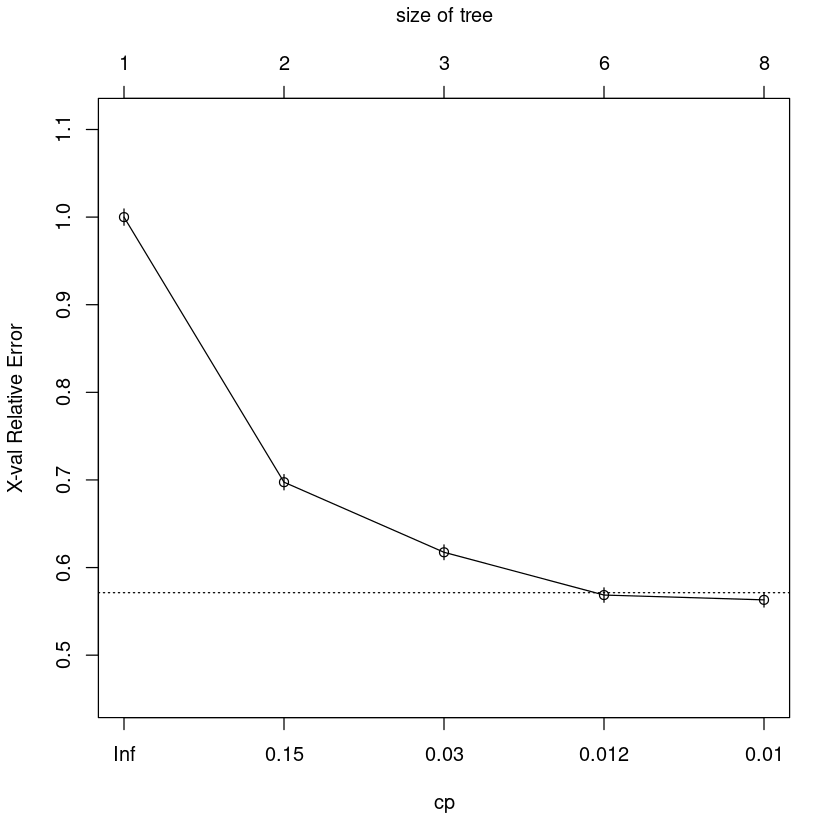

In [84]:
printcp(model) # display the results
plotcp(model) # visualize cross-validation results
summary(model) # detailed summary of splits

## Model 2.bis <a class="anchor" id="Model_2_1_Boosted_Decision_Tree"></a>

In [87]:
install.packages("tree")

Installing package into ‘/home/seb/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)



In [40]:
training_set_labels <- read.csv("sample_data/training_set_labels.csv", stringsAsFactors  = T)
spam_bis <- data.frame(training_set_features[2:length(training_set_features)], training_set_labels[3])
# spam_bis$h1n1_vaccine


In [93]:
training_set_labels <- read.csv("sample_data/training_set_labels.csv", stringsAsFactors  = T)

training_set_features <- read.csv("sample_data/training_set_features.csv", stringsAsFactors  = T)
test_set_features <- read.csv("sample_data/test_set_features.csv", stringsAsFactors  = T)
# training_set_features <- data_sorting(training_set_features)
training_set_features <- cleanData(training_set_features)
training_set_features <- transform_na(training_set_features, 33)
training_set_features <- transform_na(training_set_features, 34)
test_set_features <- cleanData(test_set_features)
test_set_features <- transform_na(test_set_features, 33)
test_set_features <- transform_na(test_set_features, 34)
# training_set_features <- subset(training_set_features, select = -35)
# training_set_features <- subset(training_set_features, select = -35)

spam_bis <- data.frame(training_set_features[2:length(training_set_features)], training_set_labels[3])
library(tree)
# library(rpart)



# Parameters of the algorithm
n_trees <- 15
N <- nrow(spam_bis)


alpha_vec <- array(NA,n_trees)
misclassification_vec <- array(NA,n_trees)


# Rescaling target variable
# data(spam_bis)
spam_bis$seasonal_vaccine <- ifelse(spam_bis$seasonal_vaccine == 1,-1,1) # Data in {-1,+1}
# spam_bis$h1n1_vaccine
target_variable <- ncol(spam_bis)


# 50/50 data split
spam_idx <- sample(1:N)
half_split <- floor(N/2)
train_data <- spam_bis[spam_idx[1:half_split],]
test_data <- spam_bis[spam_idx[(half_split+1):nrow(spam_bis)],]


# Prediction - Single tree
tree_model <-tree(seasonal_vaccine ~ ., train_data,
                  control=tree.control(half_split,mincut=20))

# tree_model <-rpart(h1n1_vaccine ~ ., train_data,
#                   control=rpart.control(half_split,mincut=10))

Y_pred_tree <- sign(predict(tree_model,test_data))

# Boosting
Y_pred_boosting <- rep(0,length(test_data))
w <- array(1/half_split,half_split)
# set.seed(555)

# For each boosting iteration
for(j in 1:n_trees){
    
    #1. Sample from the training set
    selected_samples <- sample(1:half_split,1,replace=TRUE,prob=w)
    print(paste("[INFO] - Training set size:",dim(train_data)[1],"- Testing set size",dim(test_data)[1]))
    
    #2. Fit a model on the training set and evaluate it on the training set
     tree_model <-tree(seasonal_vaccine ~ ., train_data[selected_samples,],
                  control=tree.control(half_split,mincut=20))
#     tree_model <-rpart(h1n1_vaccine ~ ., train_data[selected_samples,],
#                   control=rpart.control(half_split,mincut=10))
    Y_pred_train <- sign(predict(tree_model,train_data))
    #3. Compute misclassification on training set
    misclassification_vec[j] <- sum(w*as.double(train_data$seasonal_vaccine != sign(Y_pred_train)))/sum(w)
#     cat("Checking the missclassification value : ",misclassification_vec[j], " At the run : ", j, "\n")
    
    #4. Computation of alpha and updating of resampling weight
    alpha_vec[j] <- log((1-misclassification_vec[j])/misclassification_vec[j])  
    w <- w * exp(alpha_vec[j]*as.integer(train_data$seasonal_vaccine != sign(Y_pred_train)))
#     cat("Checking if there is an NA in w : ", mean(w), " At the run : ", j, "\n")
    
    
    #5. Normalize the weights in order to represent a true distribution
    
    w <- w/sum(w)

    
    #6. Compute the predictions on the testing set and weight them by alpha
    Y_pred_boosting<-Y_pred_boosting+alpha_vec[j]*predict(tree_model,test_data)


}


# Misclassification error comparation
misclassification_error_base <- sum(as.numeric(test_data$seasonal_vaccine != sign(Y_pred_tree)))/length(Y_pred_tree)
misclassification_error_boosting <- sum(as.numeric(test_data$seasonal_vaccine != sign(Y_pred_boosting)))/length(Y_pred_boosting)

print(paste("[INFO] - Misclassification rate - Single tree:",misclassification_error_base))
print(paste("[INFO] - Misclassification rate - Boosted tree:",misclassification_error_boosting))


[1] "[INFO] - Training set size: 13353 - Testing set size 13354"


Warning message in Y_pred_boosting + alpha_vec[j] * predict(tree_model, test_data):
“longer object length is not a multiple of shorter object length”


[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Training set size: 13353 - Testing set size 13354"
[1] "[INFO] - Misclassification rate - Single tree: 0.273850531675902"
[1] "[INFO] - Miscl


## Model 3 <a class="anchor" id="Model_3_Random_Forest"></a>


In [42]:
install.packages("randomForest")

Installing package into ‘/home/seb/R/x86_64-pc-linux-gnu-library/4.2’
(as ‘lib’ is unspecified)



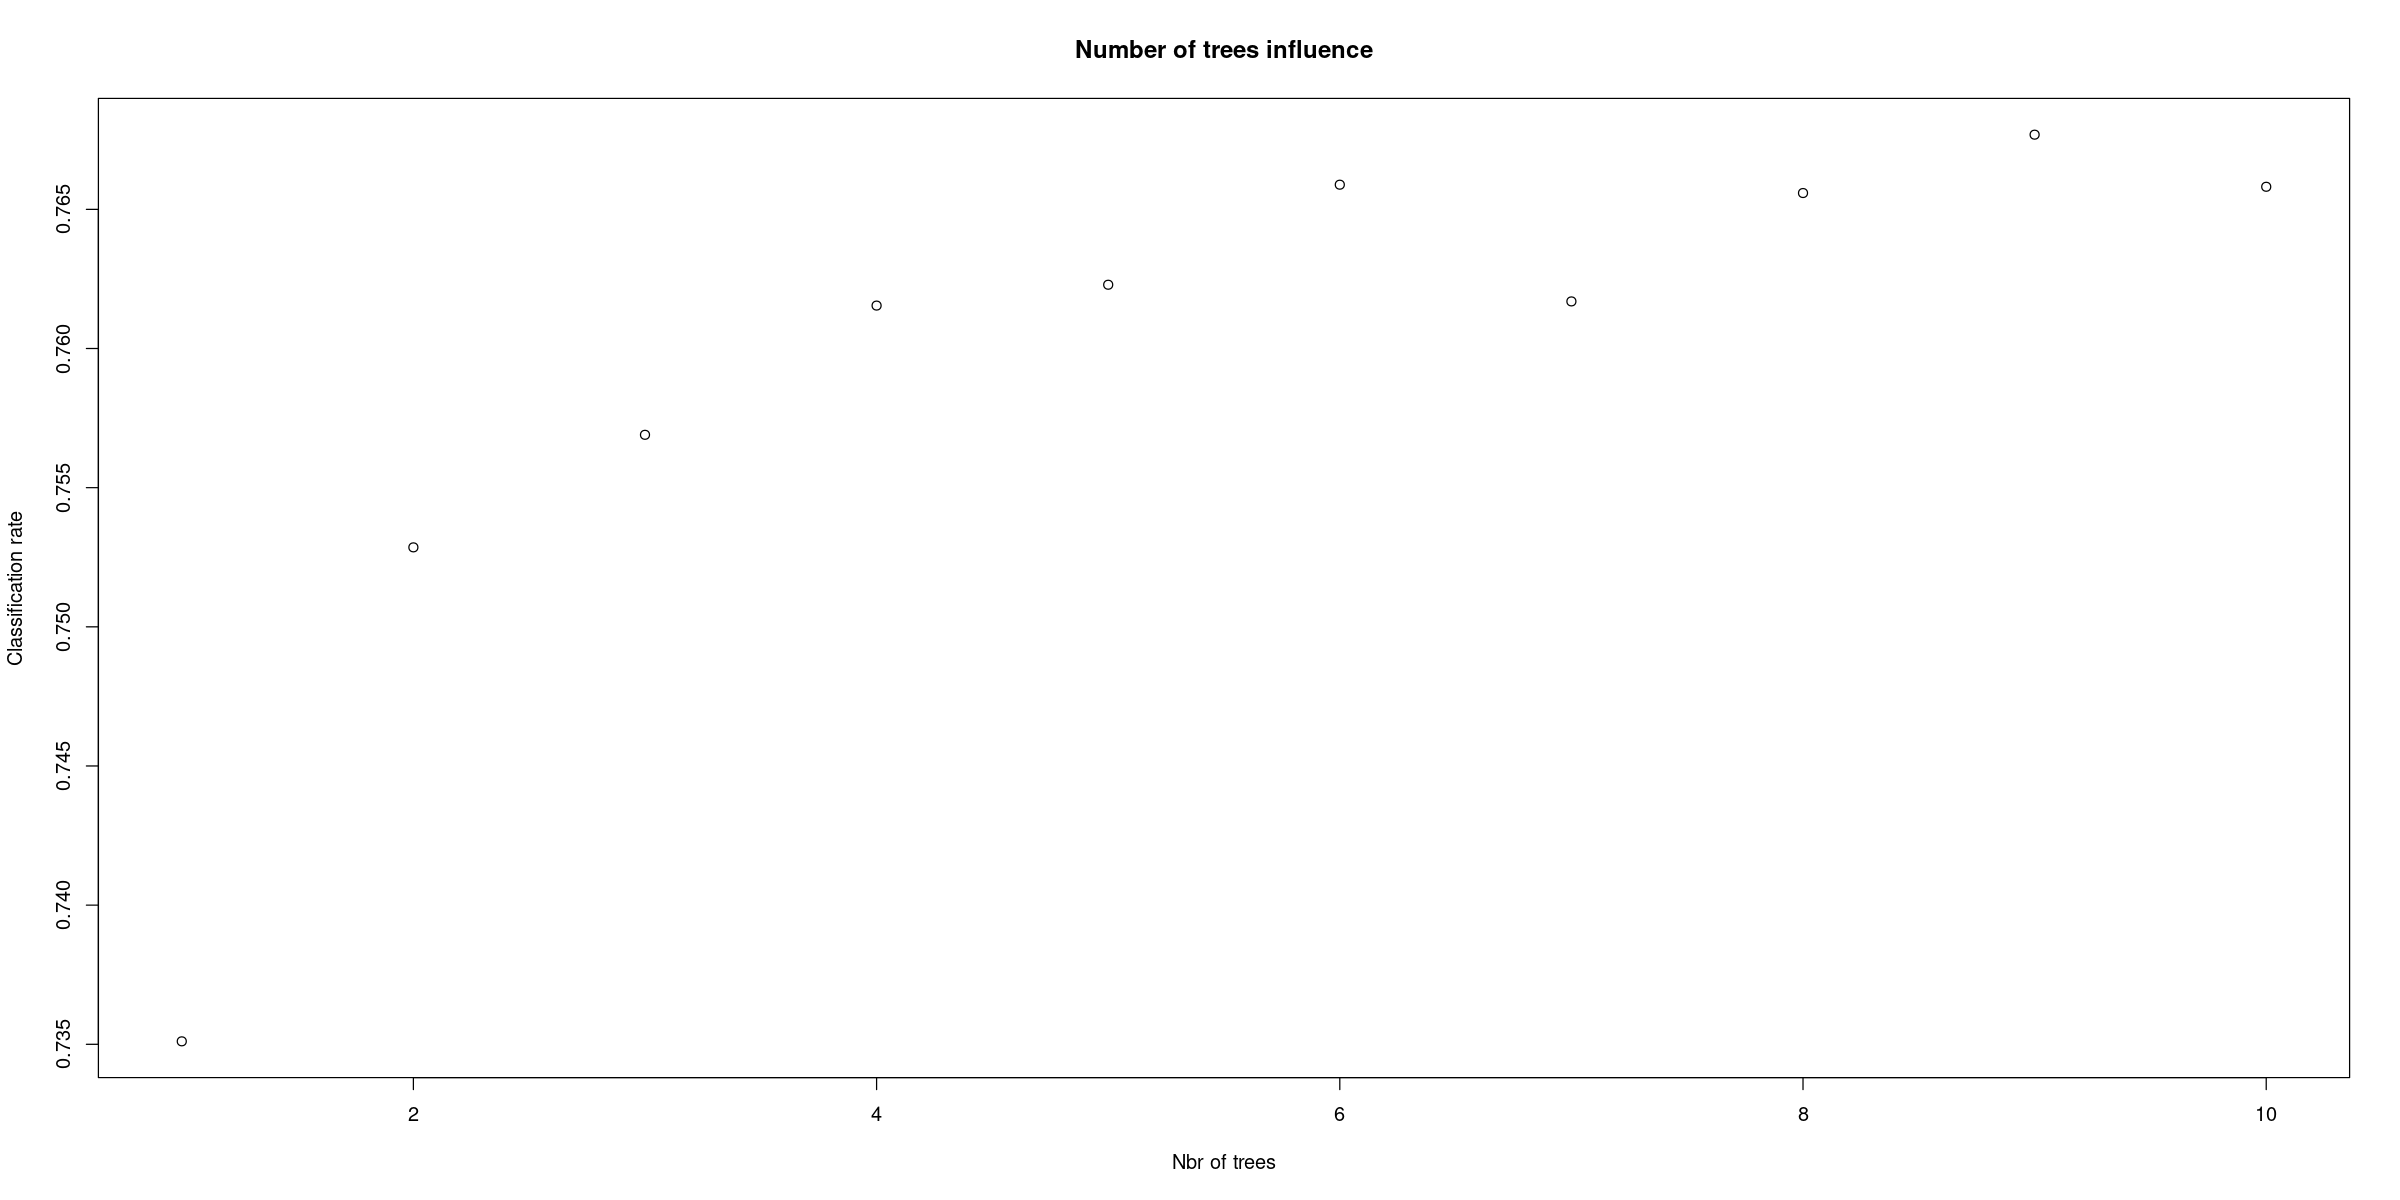

In [45]:
library("randomForest")
spam <- data.frame(training_set_features[2:length(training_set_features)], training_set_labels[3]) 
n_trees <- 10
accuracy_vec <- array(0,n_trees)

spam_idx <- sample(1:nrow(spam))
half_split <- floor(nrow(spam)/2)
target_variable <- ncol(spam)

for (i in 1:n_trees){ #print(i)
    #3.1 Take the first half of the dataset as a training data set
    train_data <- spam[spam_idx[1:half_split],]

    #3.2 Take the second half of the dataset as a hold out or test data set
    test_data <- spam[spam_idx[(half_split+1):nrow(spam)],]
    
    model <- randomForest(x=train_data[,-c(target_variable)],
                          y=as.factor(train_data[,c(target_variable)]),
                          xtest=test_data[,-c(target_variable)],
                          ytest=as.factor(test_data[,c(target_variable)]),
                          ntree=i*10)
    
    accuracy_vec[i] = (model$test$confusion[1,1]+model$test$confusion[2,2])/sum(model$test$confusion)
    }
plot(accuracy_vec,main = "Number of trees influence",xlab = "Nbr of trees",ylab = "Classification rate")

In [ ]:
 ?numeric()

In [ ]:
install.packages("randomForest")

Installing package into ‘/home/seb/R/x86_64-pc-linux-gnu-library/4.2’
(as ‘lib’ is unspecified)



In [59]:
library("randomForest")
spam <- data.frame(training_set_features[2:length(training_set_features)], training_set_labels[2]) 
head(spam)
head(test_set_features)
# head(spam)
n_trees <- 100 # 600 = 0.8385 precision
threshold <- 0.5


accuracy_vec <- array(0,n_trees)

spam_idx <- sample(1:nrow(spam))
half_split <- floor(nrow(spam)/2)
target_variable <- ncol(spam)

train_data <- spam[spam_idx[1:half_split],]

test_data <- spam[spam_idx[(half_split+1):nrow(spam)],]
    
model <- randomForest(x=train_data[,-c(target_variable)],
                          y=as.factor(train_data[,c(target_variable)]),
                          xtest=test_data[,-c(target_variable)],
                          ytest=as.factor(test_data[,c(target_variable)]),
                          ntree=n_trees, 
                          keep.forest=TRUE)

Y_pred <- data.frame(predict(model,test_set_features[2:length(test_set_features)]))
submission <- data.frame(submission_format[1], Y_pred)



spam <- data.frame(training_set_features[2:length(training_set_features)], training_set_labels[3]) 
n_trees <- 90 # 800 = 0.772 precision
accuracy_vec <- array(0, n_trees)

spam_idx <- sample(1:nrow(spam))
half_split <- floor(nrow(spam)/2)
target_variable <- ncol(spam)

train_data <- spam[spam_idx[1:half_split],]

test_data <- spam[spam_idx[(half_split+1):nrow(spam)],]
    
model <- randomForest(x=train_data[,-c(target_variable)],
                          y=as.factor(train_data[,c(target_variable)]),
                          xtest=test_data[,-c(target_variable)],
                          ytest=as.factor(test_data[,c(target_variable)]),
                          ntree=n_trees, 
                          keep.forest=TRUE)

Y_pred <- data.frame(predict(model, test_set_features[2:length(test_set_features)]))
submission <- data.frame(submission, Y_pred)
x <- submission
levels(x[,2]) <- c("0.0", "1.0")
levels(x[,3]) <- c("0.0", "1.0")
write.csv(x,"sample_data/answers.csv", row.names = FALSE, quote=FALSE)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,⋯,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<int>
1,1,0,0,0,0,0,0,1,1,0,⋯,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0,0,,,0
2,3,2,0,1,0,1,0,1,1,0,⋯,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0,0,pxcmvdjn,xgwztkwe,0
3,1,1,0,1,0,0,0,0,0,0,⋯,Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2,0,rucpziij,xtkaffoo,0
4,1,1,0,1,0,1,1,0,0,0,⋯,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0,0,,,0
5,2,1,0,1,0,1,1,0,1,0,⋯,Married,Own,Employed,qufhixun,"MSA, Not Principle City",1,0,wxleyezf,emcorrxb,0
6,3,1,0,1,0,1,0,0,1,0,⋯,Married,Own,Employed,atmpeygn,"MSA, Principle City",2,3,saaquncn,vlluhbov,0


,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,⋯,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>
1,26707,2,2,0,1,0,1,1,0,1,⋯,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1,0,atmlpfrs,hfxkjkmi
2,26708,1,1,0,0,0,0,0,0,0,⋯,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3,0,atmlpfrs,xqwwgdyp
3,26709,2,2,0,0,1,1,1,1,1,⋯,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1,0,nduyfdeo,pvmttkik
4,26710,1,1,0,0,0,0,0,0,0,⋯,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1,0,,
5,26711,3,1,1,1,0,1,1,1,1,⋯,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0,1,fcxhlnwr,mxkfnird
6,26712,2,2,0,1,0,1,1,0,1,⋯,"> $75,000",Not Married,Own,Employed,mlyzmhmf,"MSA, Principle City",0,2,fcxhlnwr,cmhcxjea



#### Example of simple equation
\begin{equation}
e = mc^2
\end{equation}

#### Example of matrix equation - Cross product formula:

\begin{equation*}
\mathbf{V}_1 \times \mathbf{V}_2 =  
\begin{vmatrix}
\mathbf{i} & \mathbf{j} & \mathbf{k} \\
\frac{\partial X}{\partial u} &  \frac{\partial Y}{\partial u} & 0 \\
\frac{\partial X}{\partial v} &  \frac{\partial Y}{\partial v} & 0
\end{vmatrix}
\end{equation*}

#### Example of multiline equation - The Lorenz Equations:

\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}

#### Example of Markdown Table:

| This | is   |
|------|------|
|   a  | table|


# Alternative models





# Conclusions